In [1]:
%%capture capt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import pickle

### Dictionnaires de GridSearch pour les meilleurs paramètres de chaque fonction

In [2]:
with open('../data/grid_search/gridSearch.pickle', 'rb') as handle:
    grid_search = pickle.load(handle)
print(len(grid_search))

4199


In [3]:
with open('../data/grid_search/gridSearch_norm.pickle', 'rb') as handle:
    grid_search_norm = pickle.load(handle)
print(len(grid_search_norm))

4226


In [4]:
with open('../data/grid_search/gridSearch_scaled.pickle', 'rb') as handle:
    grid_search_scaled = pickle.load(handle)
print(len(grid_search_scaled))

4646


In [5]:
def get_nb_clusters_from_key(key):
    return int(key.split(',')[0].split(':')[-1])

def get_meilleurs_params(dic, max_clusters=None):
    max_score = -float('inf')
    max_key = ''
    if not max_clusters:
        max_clusters = float('inf')
        
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) <= max_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [6]:
best_params_norm = get_meilleurs_params(grid_search_norm)
print(f"Meilleurs params normalise --> {best_params_norm}")

Meilleurs params normalise --> (0.058388449763529505, 'n_clusters:33, weights:50 5 1')


In [7]:
best_params = get_meilleurs_params(grid_search)
print(f"Meilleurs params non normalise --> {best_params}")

Meilleurs params non normalise --> (0.05881224330601615, 'n_clusters:5, weights:50 50 5')


In [8]:
best_params_scaled = get_meilleurs_params(grid_search_scaled)
print(f"Meilleurs params scaled --> {best_params_scaled}")

Meilleurs params scaled --> (0.9684855479335592, 'n_clusters:39, weights:45 10 1')


In [9]:
range_max_clusters = range(5, 30)
best_params_scaled = [get_meilleurs_params(grid_search_scaled, max_clusters=max_clusters)[0] for max_clusters in range_max_clusters]

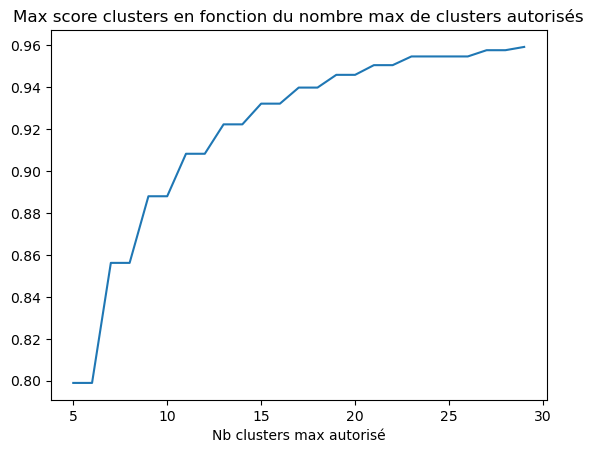

In [10]:
plt.plot(range_max_clusters, best_params_scaled)
plt.title("Max score clusters en fonction du nombre max de clusters autorisés")
plt.xlabel("Nb clusters max autorisé")
plt.show()

### Clustering pour chacun des meilleurs params

In [11]:
%run Calculate_clusters.ipynb

Installation/Importation des librairies necessaires.
CPU cores available -> 56


In [12]:
def get_weights_from_params(params):
    key = params[1].split(',')[-1].split(':')[-1].split(' ')
    weights_params = [int(weight) for weight in key]
    return weights_params

In [13]:
import warnings
warnings.filterwarnings("ignore")

###### Custom scaled

In [14]:
best_params_scaled_15 = get_meilleurs_params(grid_search_scaled, max_clusters=15)
print(best_params_scaled_15)

(0.9322219652330211, 'n_clusters:15, weights:25 15 10')


In [15]:
kmedoids_scaled_15, base_scaled_15 = base_finale(X_patient, 'custom', scaled=True, 
                                                 weights_metric=get_weights_from_params(best_params_scaled_15), 
                                                 n_clusters = get_nb_clusters_from_key(best_params_scaled_15[-1]))

KeyboardInterrupt: 

###### Custom norm

In [ ]:
best_params_norm = get_meilleurs_params(grid_search_norm)
print(best_params_norm)

In [ ]:
kmedoids_norm, base_norm = base_finale(X_patient, 'custom_norm', scaled=False, 
                                       weights_metric=get_weights_from_params(best_params_norm), 
                                       n_clusters = get_nb_clusters_from_key(best_params_norm[-1]))

###### Custom

In [ ]:
best_params = get_meilleurs_params(grid_search)
print(best_params)

In [ ]:
kmedoids_std, base_std = base_finale(X_patient, 'custom', scaled=False, 
                                     weights_metric=get_weights_from_params(best_params), 
                                     n_clusters = get_nb_clusters_from_key(best_params[-1]))